In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import itertools
import time
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import jax

import jax.numpy as jnp
import netket as nk


/home/cwpark/acband-laughlin-instability/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


∣NK⟩ Tip: With many Markov Chains (e.g GPUs), n_discard_per_chain>5 is often inefficient.

In [2]:
from src.qm_utils.lattice.lattice import Lattice2D
from src.qm_utils.lattice.brillouin_zone import BrillouinZone2D
from src.netket_compat import get_sector_constraints
from src.acband import acband_form_factors, K_func1

In [13]:
N_s = 25
N_f = 19

In [20]:
bz = {}

sqrt3 = np.sqrt(3)
e1 = np.array([1, 0])
e2 = np.array([0, 1])
a_M = 1.0
a1 = a_M * e2
a2 = a_M * ((-sqrt3 / 2) * e1 + (1 / 2) * e2)
lattice = Lattice2D(np.stack([a1, a2]))
b = (4 * np.pi) / (a_M * sqrt3)
b1, b2 = lattice.reciprocal_lattice_vectors
b3 = -(b1 + b2)

# N = 27 grid
t1 = (1 / 9) * (b1 - b2)
t2 = (1 / 9) * (b1 - b3)
t3 = (1 / 9) * (b2 - b3)

sample_lattice_27 = Lattice2D(np.stack([t1, t2]))
bz_27 = BrillouinZone2D(lattice, sample_lattice_27)
bz[27] = bz_27

# N = 28 grid
p1 = b1 + t2 - t1
normb1 = np.linalg.norm(b1)
normp1 = np.linalg.norm(p1)
distb1p1 = np.linalg.norm(b1 - p1)
scale = normb1 / normp1
rot = -np.arccos((normb1 ** 2 + normp1 ** 2 - distb1p1 ** 2) / (2 * normb1 * normp1))
sample_lattice_28 = sample_lattice_27.transformed(scale=scale, rot=rot)

bz_28 = BrillouinZone2D(lattice, sample_lattice_28)
bz[28] = bz_28

# N = 25 grid
p1 = b1 + 2 * t3 - t1
normb1 = np.linalg.norm(b1)
normp1 = np.linalg.norm(p1)
distb1p1 = np.linalg.norm(b1 - p1)
scale = normb1 / normp1
rot = -np.arccos((normb1 ** 2 + normp1 ** 2 - distb1p1 ** 2) / (2 * normb1 * normp1))
sample_lattice_25 = sample_lattice_27.transformed(scale=scale, rot=rot)

bz_25 = BrillouinZone2D(lattice, sample_lattice_25)
bz[25] = bz_25

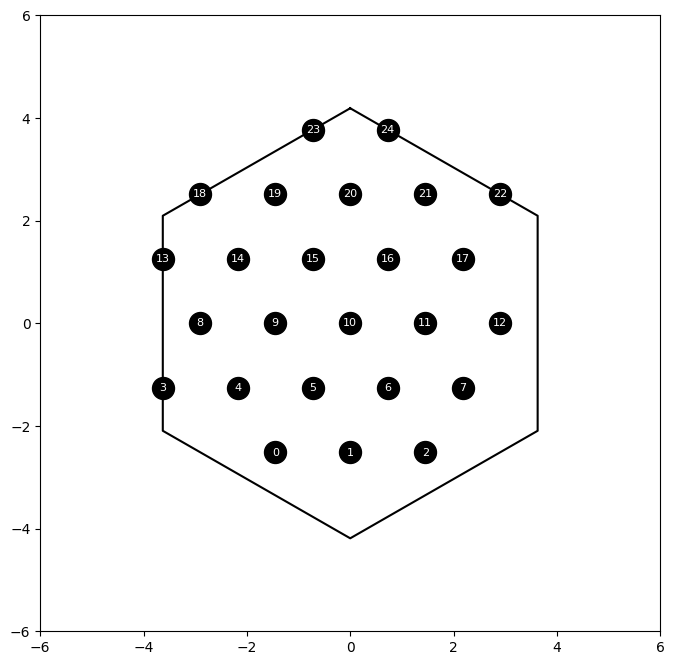

In [ ]:
bz_N_s = bz[N_s]
sampled_momentums = bz_N_s.k_points
R = 3 * np.linalg.norm(t1)
thetas = np.linspace(np.pi / 2, 5 * np.pi / 2, 7)
hexagon_x = R * np.cos(thetas)
hexagon_y = R * np.sin(thetas)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
k_x = sampled_momentums[:, 0]
k_y = sampled_momentums[:, 1]
ax.scatter(k_x, k_y, s=250, c='k')
for i in range(N_s):
    x = k_x[i]
    y = k_y[i]
    ax.text(x, y, f"{i}", fontsize=8, color="w", ha='center', va='center')

ax.plot(hexagon_x, hexagon_y, color='k')

ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
plt.show()

In [ ]:
constraints = get_sector_constraints(bz_N_s, N_f)
hilbs = [
    nk.hilbert.SpinOrbitalFermions(
        n_orbitals=N_s, n_fermions=N_f, constraint=constraint
    ) for constraint in constraints
]

In [ ]:
for k_index, sector in enumerate(hilbs):
    print(f"Sector {k_index}:")
    print(f"  Total Momentum: {bz_N_s[k_index]}")
    print(f"  Dimension: {sector.n_states}")

Sector 0:
  Total Momentum: [-1.45103949 -2.51327412]
  Dimension: 7084
Sector 1:
  Total Momentum: [-2.22044605e-16 -2.51327412e+00]
  Dimension: 7084
Sector 2:
  Total Momentum: [ 1.45103949 -2.51327412]
  Dimension: 7084
Sector 3:
  Total Momentum: [-3.62759873 -1.25663706]
  Dimension: 7084
Sector 4:
  Total Momentum: [-2.17655924 -1.25663706]
  Dimension: 7084
Sector 5:
  Total Momentum: [-0.72551975 -1.25663706]
  Dimension: 7084
Sector 6:
  Total Momentum: [ 0.72551975 -1.25663706]
  Dimension: 7084
Sector 7:
  Total Momentum: [ 2.17655924 -1.25663706]
  Dimension: 7084
Sector 8:
  Total Momentum: [-2.90207898e+00 -8.79881505e-18]
  Dimension: 7084
Sector 9:
  Total Momentum: [-1.45103949e+00 -4.39940752e-18]
  Dimension: 7084
Sector 10:
  Total Momentum: [0. 0.]
  Dimension: 7084
Sector 11:
  Total Momentum: [1.45103949e+00 4.39940752e-18]
  Dimension: 7084
Sector 12:
  Total Momentum: [2.90207898e+00 8.79881505e-18]
  Dimension: 7084
Sector 13:
  Total Momentum: [-3.62759873  

In [28]:
lB = 1.0
resolution = 254
# resolution = 1022
v1 = 1.0
A = N_s * lattice.unit_cell_area

def V(q):
    return -v1 * np.linalg.norm(q) ** 2
    
K_func = partial(K_func1, args=(0.8, b1, b2, b3))

start = time.time()
G_coords, ac_ff = acband_form_factors(
    bz[N_s],
    lB,
    K_func,
    resolution
)
G_idx_map = {tuple(G.tolist()): i for i, G in enumerate(G_coords)}
end = time.time()

print(f"N_s = {N_s} AC band form factors computed in {end - start:.2f} seconds")
print(f"{ac_ff.shape=}")

N_s = 25 AC band form factors computed in 2.25 seconds
ac_ff.shape=(7, 25, 25)


In [ ]:
from netket.operator.fermion import destroy as c
from netket.operator.fermion import create as cdag

hamiltonians = []
for sector in hilbs:
    H = 0.0
    
    for k1, k2, p in itertools.product(range(N_s), repeat=3):
        k1_coords = bz_N_s.k_coords[k1]
        k2_coords = bz_N_s.k_coords[k2]
        p_coords = bz_N_s.k_coords[p]
        
        k1_f_coords = k1_coords + p_coords
        k2_f_coords = k2_coords - p_coords
        
        k1_f_folded, g1 = bz_N_s.fold_coord(k1_f_coords)
        k2_f_folded, g2 = bz_N_s.fold_coord(k2_f_coords)
        
        k1_f = bz_N_s.idx_from_coord[k1_f_folded]
        k2_f = bz_N_s.idx_from_coord[k2_f_folded]

        g1_idx = G_idx_map[tuple(g1.tolist())]
        g2_idx = G_idx_map[tuple(g2.tolist())]
        
        Lambda1 = ac_ff[g1_idx, k1_f, k1]
        Lambda2 = ac_ff[g2_idx, k2_f, k2]
        
        p_vec = bz_N_s.k_points[p]
        V_p = V(p_vec)
        c_dag_k1_f = cdag(sector, k1_f)
        c_dag_k2_f = cdag(sector, k2_f)
        c_k2 = c(sector, k2)
        c_k1 = c(sector, k1)
        H += complex((1 / (2 * A)) * V_p * Lambda1 * Lambda2) * (c_dag_k1_f @ c_dag_k2_f @ c_k2 @ c_k1)
    hamiltonians.append(H)

In [34]:
spectrums = []
com_momentums = []

for k_index, (sector, H) in enumerate(zip(hilbs, hamiltonians)):
    print(f"Diagonalizing sector {k_index} with dimension {sector.n_states}...")
    start = time.time()
    evals = nk.exact.lanczos_ed(H, k=30)
    end = time.time()
    print(f"  Diagonalized in {end - start:.2f} seconds")
    spectrums.append(evals)
    com_momentums.append(bz_N_s.k_points[k_index])

Diagonalizing sector 0 with dimension 7084...
  Diagonalized in 3.52 seconds
Diagonalizing sector 1 with dimension 7084...
  Diagonalized in 3.89 seconds
Diagonalizing sector 2 with dimension 7084...
  Diagonalized in 4.26 seconds
Diagonalizing sector 3 with dimension 7084...
  Diagonalized in 3.87 seconds
Diagonalizing sector 4 with dimension 7084...
  Diagonalized in 4.86 seconds
Diagonalizing sector 5 with dimension 7084...
  Diagonalized in 4.13 seconds
Diagonalizing sector 6 with dimension 7084...
  Diagonalized in 4.31 seconds
Diagonalizing sector 7 with dimension 7084...
  Diagonalized in 3.69 seconds
Diagonalizing sector 8 with dimension 7084...
  Diagonalized in 4.16 seconds
Diagonalizing sector 9 with dimension 7084...
  Diagonalized in 3.91 seconds
Diagonalizing sector 10 with dimension 7084...
  Diagonalized in 4.04 seconds
Diagonalizing sector 11 with dimension 7084...
  Diagonalized in 3.62 seconds
Diagonalizing sector 12 with dimension 7084...
  Diagonalized in 3.39 seco

In [35]:
k_coms_flatten = []
energies_flatten = []

for com_momentum, spectrum in zip(com_momentums, spectrums):
    k_coms_flatten.extend([np.linalg.norm(com_momentum)] * len(spectrum))
    energies_flatten.extend(spectrum.tolist())
    
k_coms_flatten = np.array(k_coms_flatten)
energies_flatten = np.array(energies_flatten)
energies_flatten -= np.min(energies_flatten)

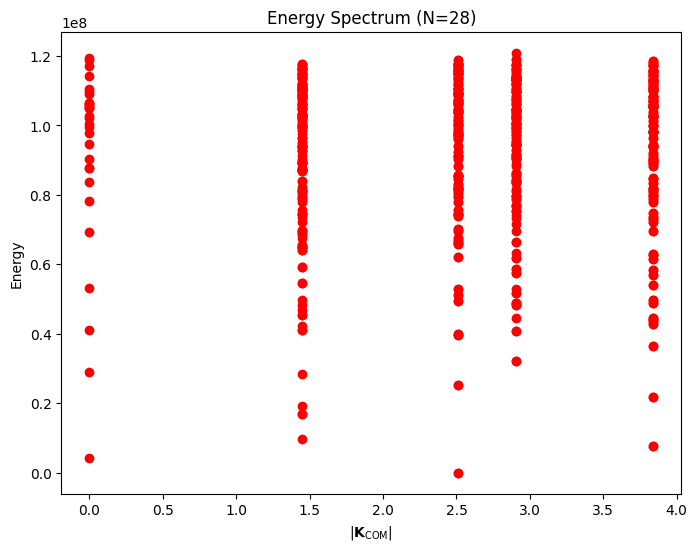

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(k_coms_flatten, energies_flatten, color='red')
plt.xlabel(r'$|\mathbf{k}_{\mathrm{COM}}|$')
plt.ylabel('Energy')
plt.title(f'Energy Spectrum (N={N_s})')
plt.show()